**Código-exemplo para disciplina de Deep Learning: Convolução**

Código para aproveitamento dos treinos já aprendidos pela VGG16. Para outras redes, acesse: https://keras.io/api/applications/

Abril/2023

Professor: Sérgio Canuto



In [1]:
import tensorflow as tf
from tensorflow import keras
import warnings
warnings.filterwarnings("ignore")

In [2]:
tf.__version__

'2.10.0'

In [3]:
keras.__version__

'2.10.0'

**Compatibilidade com a versão 1 do tensorflow: Habilita recursos do tensorboard**




In [4]:
#tf.compat.v1.disable_v2_behavior()

In [5]:
from keras.applications.vgg16 import VGG16
from tensorflow.keras.utils import plot_model
model = VGG16()
print(model.summary(line_length = 0))
#plot_model(model, to_file='vgg.png')

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [10]:
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.utils import plot_model
model = ResNet50()
print(model.summary(line_length = 150))
#plot_model(model, to_file='resnet50.png')

Model: "resnet50"
______________________________________________________________________________________________________________________________________________________
 Layer (type)                                    Output Shape                     Param #           Connected to                                      
 input_6 (InputLayer)                            [(None, 224, 224, 3)]            0                 []                                                
                                                                                                                                                      
 conv1_pad (ZeroPadding2D)                       (None, 230, 230, 3)              0                 ['input_6[0][0]']                                 
                                                                                                                                                      
 conv1_conv (Conv2D)                             (None, 112, 112, 64)       

In [14]:
import numpy as np
from sklearn.utils import resample

#obtém os dados
fashion_mnist=keras.datasets.fashion_mnist
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()

from sklearn.utils import resample
X_train_full, y_train_full = resample(X_train_full,
                                      y_train_full,
                                      n_samples=10000,
                                      random_state=0)

In [15]:
X_valid, X_train = X_train_full[:1000]/255., X_train_full[1000:]/255.
y_valid, y_train = y_train_full[:1000], y_train_full[1000:]

In [16]:
# e transforma um canal em preto-branco em três canais em preto-e-branco:
# (necessário para entrada da VGG16)
X_train=np.dstack([X_train]*3)
X_valid=np.dstack([X_valid]*3)

X_train = X_train.reshape(-1, 28, 28, 3)
X_valid = X_valid.reshape(-1, 28, 28, 3)
print("Dimensão dos documentos de treino:")
print(X_train.shape)

Dimensão dos documentos de treino:
(9000, 28, 28, 3)


In [17]:
# "redimensiona o tamanho das imagens para" 48x48 como requisito do VGG16 pré-treinado.
# para mais informações, acesse: https://keras.io/api/applications/vgg/#vgg16-function

from tensorflow.keras.utils import img_to_array, array_to_img
X_train = np.asarray(
    [img_to_array(array_to_img(im, scale=False).resize((48,48)))
    for im in X_train]
    )
X_valid = np.asarray(
    [img_to_array(array_to_img(im, scale=False).resize((48,48)))
    for im in X_valid]
    )

X_train.shape, X_valid.shape

((9000, 48, 48, 3), (1000, 48, 48, 3))

In [20]:
from tensorflow.keras.applications.resnet50 import ResNet50
#carrega o modelo VGG16
resnet_model = ResNet50(
                weights='imagenet',
                include_top=False,
                input_shape=(48, 48, 3)
                )

# Seta as camadas iniciais para apenas leitura (não treináveis!)
for layer in resnet_model.layers[:15]:
    layer.trainable = False

print(resnet_model.summary(line_length = 150))

Model: "resnet50"
______________________________________________________________________________________________________________________________________________________
 Layer (type)                                    Output Shape                     Param #           Connected to                                      
 input_9 (InputLayer)                            [(None, 48, 48, 3)]              0                 []                                                
                                                                                                                                                      
 conv1_pad (ZeroPadding2D)                       (None, 54, 54, 3)                0                 ['input_9[0][0]']                                 
                                                                                                                                                      
 conv1_conv (Conv2D)                             (None, 24, 24, 64)         

In [22]:
#Obêm o modelo VGG e adiciona só duas camadas densas no topo do modelo para o treinamento.
model=resnet_model.output
topo_model = keras.layers.Flatten()(model)
topo_model = keras.layers.Dense(40, activation='relu')(topo_model)
topo_model = keras.layers.Dense(10, activation='softmax')(topo_model) # Softmax for multiclass
modelo_final = tf.keras.Model(inputs=resnet_model.input, outputs=topo_model)

In [24]:
print(modelo_final.summary(line_length = 150))
#plot_model(modelo_final, to_file='vgg.png')

Model: "model"
______________________________________________________________________________________________________________________________________________________
 Layer (type)                                    Output Shape                     Param #           Connected to                                      
 input_9 (InputLayer)                            [(None, 48, 48, 3)]              0                 []                                                
                                                                                                                                                      
 conv1_pad (ZeroPadding2D)                       (None, 54, 54, 3)                0                 ['input_9[0][0]']                                 
                                                                                                                                                      
 conv1_conv (Conv2D)                             (None, 24, 24, 64)            

In [25]:
modelo_final.compile(loss="sparse_categorical_crossentropy", optimizer="sgd", metrics=["accuracy"], )
history=modelo_final.fit(X_train,y_train, epochs=30, batch_size=32,validation_data=(X_valid,y_valid))

Epoch 1/30
282/282 [==============================] - 37s 100ms/step - loss: 2.0029 - accuracy: 0.2721 - val_loss: 2.3093 - val_accuracy: 0.1150
Epoch 2/30
282/282 [==============================] - 26s 93ms/step - loss: 1.7219 - accuracy: 0.3639 - val_loss: 2.3643 - val_accuracy: 0.0980
Epoch 3/30
282/282 [==============================] - 27s 94ms/step - loss: 1.5805 - accuracy: 0.4101 - val_loss: 2.0130 - val_accuracy: 0.2560
Epoch 4/30
282/282 [==============================] - 28s 100ms/step - loss: 1.5004 - accuracy: 0.4442 - val_loss: 1.6861 - val_accuracy: 0.3770
Epoch 5/30
282/282 [==============================] - 26s 93ms/step - loss: 1.4292 - accuracy: 0.4736 - val_loss: 1.6942 - val_accuracy: 0.3990
Epoch 6/30
282/282 [==============================] - 26s 93ms/step - loss: 1.3694 - accuracy: 0.4866 - val_loss: 1.7090 - val_accuracy: 0.4120
Epoch 7/30
282/282 [==============================] - 26s 93ms/step - loss: 1.3137 - accuracy: 0.5092 - val_loss: 1.8889 - val_accurac

In [26]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

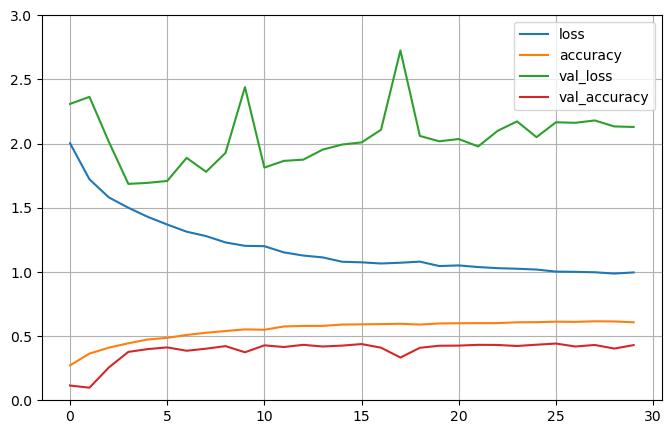

In [27]:
import pandas as pd
import matplotlib.pyplot as plt

pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,3)
plt.show()

In [28]:
X_test=np.dstack([X_test]*3)
X_test = X_test.reshape(-1, 28, 28, 3)
X_test = np.asarray(
    [img_to_array(array_to_img(im, scale=False).resize((48,48)))
    for im in X_test]
    )
X_test.shape

(10000, 48, 48, 3)

In [29]:
modelo_final.evaluate(X_test/255.,y_test)

313/313 [==============================] - 8s 26ms/step - loss: 7.9220 - accuracy: 0.1970


[7.922014236450195, 0.19699999690055847]